<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/01_Intro_to_Time_Series_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

based on notebook by Ignacio Oguiza - email: timeseriesAI@gmail.com

## Purpose 😇

The purpose of this notebook is to demonstrate both multi-class and multi-label classification using tsai.  

- Multi-class classification: While the output can take on multiple possible values, for any given sample the output can take on only a single value.  In otherwords, the label values are multually exclusive.  Implication:
  - CategoricalCrossEntropy is used as the loss function during training
  - Softmax used to determine prediction single only one label value can be true, the predicted label is the value label value with the greatest probability.
    - Softmax reduces the potential for spurrious label predictions, since only the label with the highest probability is selected
  
- Multi-label classification: This is the more general case where an individual sample can have one or more labels, relaxing the mutual lavel mutual exclusivity constraint.  Implications:
  - BinaryCrossEntropy is used as the loss function during training
  - Sigmoid used to determine prediction since mutiple labels may be true.  
    - Relative to multi-classs classification, multi-label  classification may be more prone to spurrious false-positive labels.

## Import libraries 📚

In [1]:
stable = False # True: latest version, False: stable version
import sys
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    if stable: 
        !pip install tsai -Uqq
    else:
        !pip install -Uqq git+https://github.com/timeseriesAI/tsai.git

In [2]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.16
fastai     : 2.2.7
fastcore   : 1.3.19
torch      : 1.7.0


## Prepare data 🔢

For this example we will be using the UCR ECG5000 heartbeat dataset with is based on the [Physionet BIDMC Congestive Heart Failure Database](https://physionet.org/content/chfdb/1.0.0/]), specifically recording chf07.

For the purposes of this example the UCR labels will be mapped to more descriptive labels:

- 1 - Normal ('Nor')
- 2 - R-on-T premature ventricular contraction ('RoT')
- 3 - Premature ventricular contraction ('PVC')
- 4 - Supraventricular premature or ectopic beat, atrial or nodal ('SPC')
- 5 - Unclassifiable beat ('Unk')

In [3]:
class_map = {
    '1':'Nor',  # N:1  - Normal
    '2':'RoT',  # r:2  - R-on-T premature ventricular contraction
    '3':'PVC',  # V:3  - Premature ventricular contraction
    '4':'SPC',  # S:4  - Supraventricular premature or ectopic beat (atrial or nodal)
    '5':'Unk',  # Q:5  - Unclassifiable beat
    }

In [4]:
# dataset id
dsid = 'ECG5000' 
X, y, splits = get_UCR_data(dsid, return_split=False)
y = np.array([class_map[z] for z in y])  # map tp more descriptive labels
X.shape, y.shape, splits

((5000, 1, 140),
 (5000,),
 ((#500) [0,1,2,3,4,5,6,7,8,9...],
  (#4500) [500,501,502,503,504,505,506,507,508,509...]))

In [5]:
label_counts = collections.Counter(y)
print('Counts by label:', dict(label_counts))
print(f'Naive Accuracy: {100*max(label_counts.values())/sum(label_counts.values()):0.2f}%')

Counts by label: {'Nor': 2919, 'RoT': 1767, 'PVC': 96, 'SPC': 194, 'Unk': 24}
Naive Accuracy: 58.38%


## Multi-class classification

### Prepare datasets 💿

In [6]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

In [7]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], 
                               batch_tfms=[TSStandardize()], num_workers=0)

### Visualize data

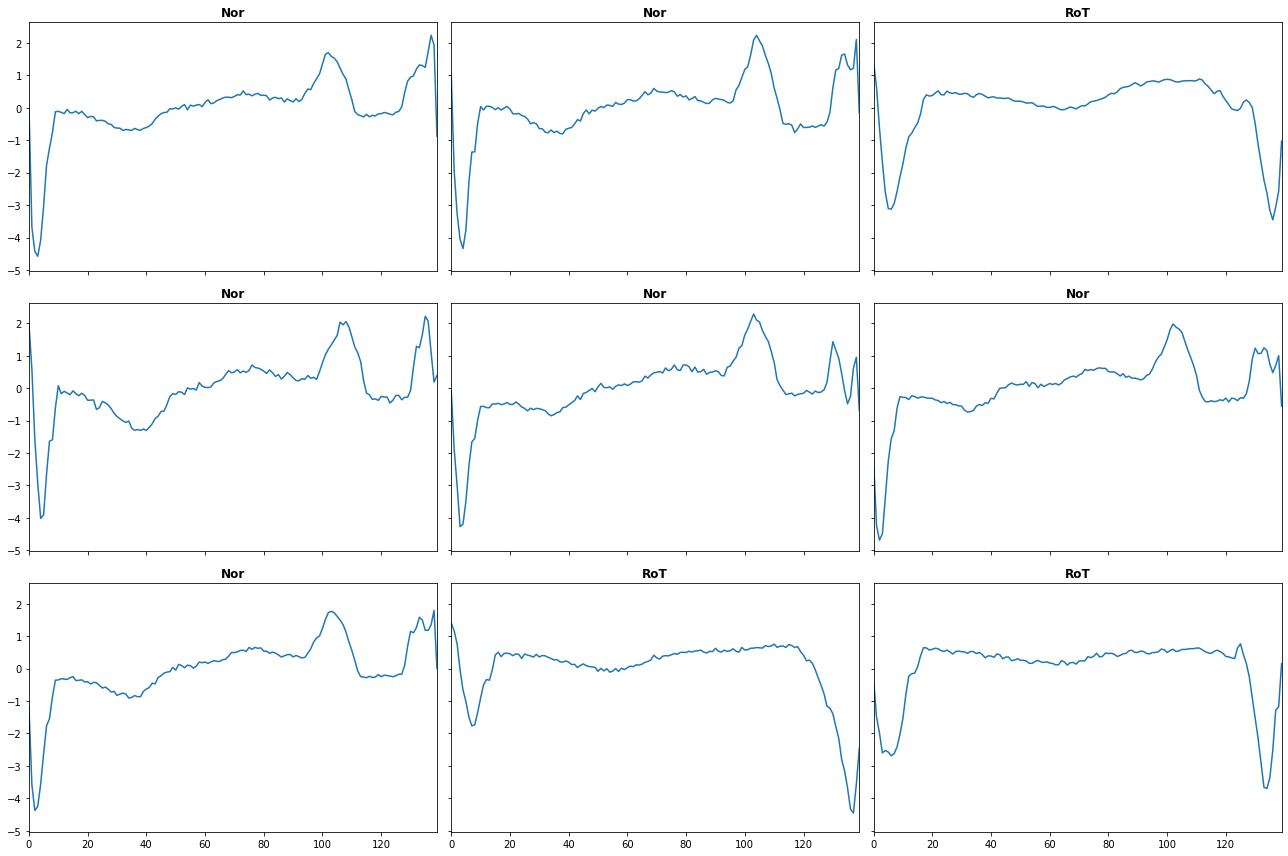

In [8]:
dls.show_batch(sharey=True)

## Build learner 🏗

### LR find 🔎

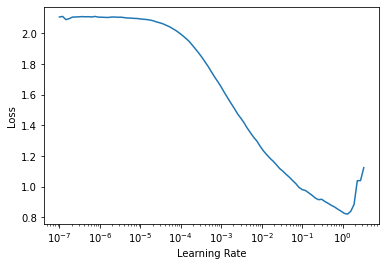

In [9]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.lr_find(suggestions=False)

### Train 🏃🏽‍♀️

epoch,train_loss,valid_loss,accuracy,time
0,1.833061,1.664469,0.038889,00:00
1,1.574355,1.615583,0.146444,00:00
2,1.290300,1.420440,0.748444,00:00
3,1.049570,0.868434,0.903333,00:00
4,0.866268,0.368681,0.930222,00:00
5,0.725461,0.267042,0.931333,00:00
6,0.623631,0.348485,0.912889,00:00
7,0.540960,0.241118,0.929556,00:00
8,0.477219,0.270097,0.930444,00:00
9,0.425835,0.279901,0.930222,00:00


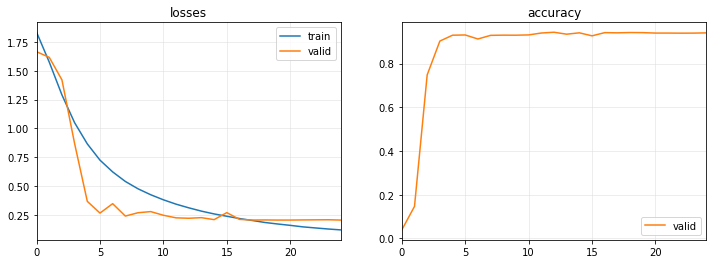

In [10]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(25, lr_max=1e-3)

learn.recorder.plot_metrics()

### Visualize results 👁

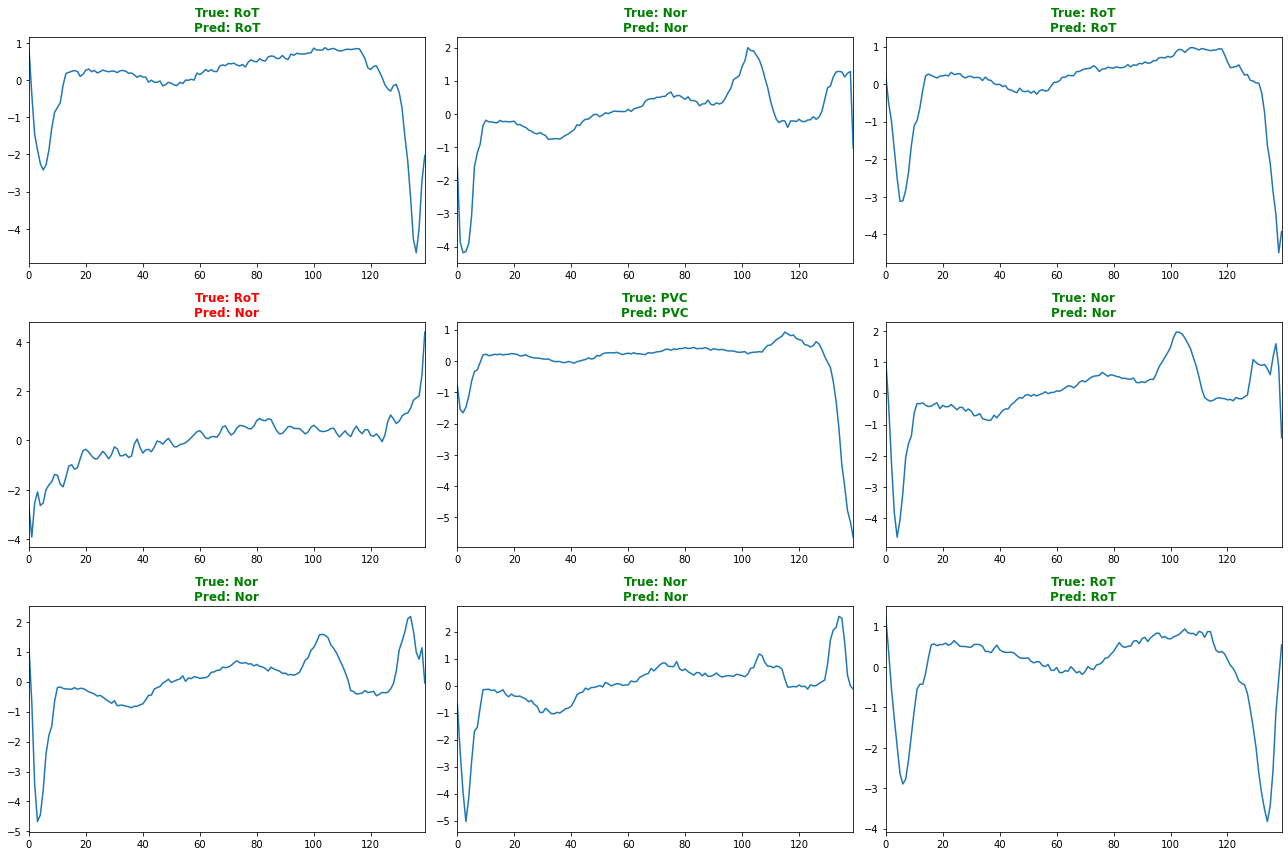

In [11]:
learn.show_results()

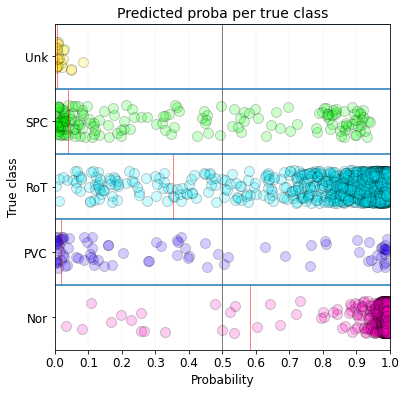

In [12]:
learn.show_probas()

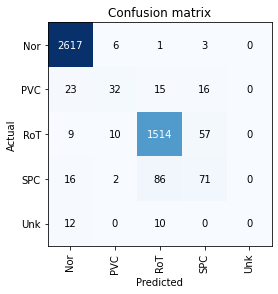

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [14]:
interp.most_confused(min_val=3)

[('SPC', 'RoT', 86),
 ('RoT', 'SPC', 57),
 ('PVC', 'Nor', 23),
 ('PVC', 'SPC', 16),
 ('SPC', 'Nor', 16),
 ('PVC', 'RoT', 15),
 ('Unk', 'Nor', 12),
 ('RoT', 'PVC', 10),
 ('Unk', 'RoT', 10),
 ('RoT', 'Nor', 9),
 ('Nor', 'PVC', 6),
 ('Nor', 'SPC', 3)]

## Multi-label Classification

### Augment labels to demonstrate multi-label

- Create additional label premature ('Pre')
- Include with any sample where labels 'RoT','PVC','SPC' are already present


Note:  While in this example the new Pre label is a composite of existing labels, more typically multi-lebel classification problems include orthiginal label groups.  For example in ECG classification one might have labels related to a) timing (e.g.: premature), QRS shape (e.g.: block) and other factors (e.g.: ST elevation or depression)

In [15]:
y_multi = [[z,'Pre'] if z in ('RoT','PVC','SPC') else [z] for z in y]

In [16]:
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

Counts by label: {'Nor': 2919, 'RoT': 1767, 'Pre': 2057, 'PVC': 96, 'SPC': 194, 'Unk': 24}


### Prepare Dataset

- Replace earlier ```tfms  = [None, [Categorize()]]```  with ```tfms  = [None, [MultiCategorize, OneHotEncode]]```
- Note:  ```OneHotEncode``` must be included explicitly

In [17]:
tfms  = [None, [MultiCategorize, OneHotEncode]]
dsets = TSDatasets(X, y_multi, tfms=tfms, splits=splits)

/home/doug/anaconda3/envs/tsai2/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


**Notes**: 
- Calling TSDatasets with ```inplace=False``` causes in error in subsequent ```dls = TSDataLoaders.from_dsets() ``` step
- Warning message *Creating an ndarray from ragged nested sequences* is expected behavior

In [18]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], 
                               batch_tfms=[TSStandardize()], num_workers=0)

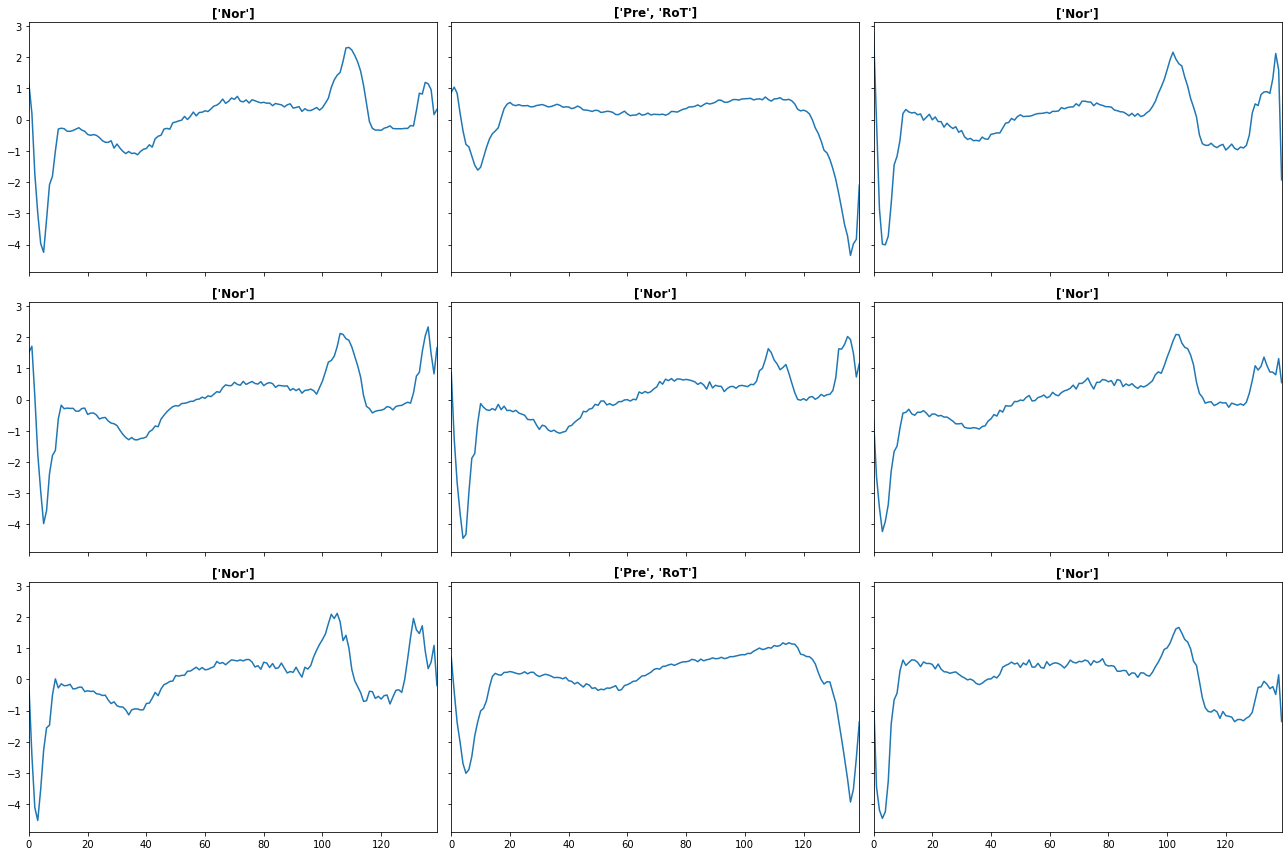

In [19]:
dls.show_batch(sharey=True)

### Build Learner and Train

- Use ```learn = ts_learner()```.  Use of ```learn = Learner()``` will fail
- Also include model name in ```ts_learner``` rather than passing pre-created model
- Use ```metrics=accuracy_multi``` in place of ```metrics=accuracy``` used inn earlier multi-class example
- Explicitly specify loss function ```loss_func=BCEWithLogitsLossFlat()```. If omitted, loss function will be ```FlattenedLoss of MSELoss()```.

In [20]:
learn = ts_learner(dls, InceptionTime,
                       metrics=accuracy_multi, 
                       loss_func=BCEWithLogitsLossFlat()
                  )

In [21]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

SuggestedLRs(lr_min=0.17378008365631104, lr_steep=0.00478630093857646)

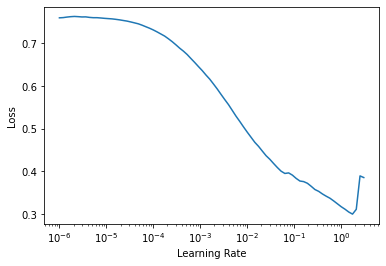

In [22]:
learn.lr_find(suggestions=True, start_lr=1e-06, end_lr=1e2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.338056,13.311313,0.792704,00:00
1,0.262753,458.911469,0.792704,00:00
2,0.212589,108.549614,0.792704,00:00
3,0.183284,17.888062,0.792889,00:00
4,0.159214,0.254651,0.969185,00:00
5,0.138950,0.127112,0.972222,00:00
6,0.123913,0.096833,0.974037,00:00
7,0.112332,0.092775,0.974592,00:00
8,0.101852,0.090027,0.974519,00:00
9,0.095169,0.089379,0.974481,00:00


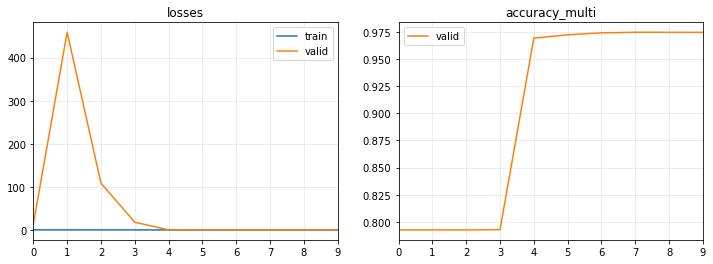

In [23]:
learn.fit_one_cycle(10, lr_max=1e-1)
learn.plot_metrics()

### Observations

- Accurracy may appear inflated since it it computed at a micro level (per label) rather than per-sample.  This is because in most cases and individual label will be False, so that the True-Negative (TN) instances will dominate the accuracy computation
- This micro-level behavior can also skew the computaation of the loss function

## Additional Multi-label Metrics

A naive classifier that always predicts no true labels would achieve 76% accuracy, so the classifier should do much better.  This also demonstrates the weakness of relying overly on the accuracy metric since due to the prevalance of false outputs.

In [24]:
label_counts = collections.Counter([a for r in y_multi for a in r])
print(f'Naive Accuracy: {100*(1-sum(label_counts.values())/(len(y_multi)*len(label_counts))):0.2f}%')

Naive Accuracy: 76.48%


### Define Metrics

Many of the multi-label metrics includes with FastAI produce errors.  Below are additional metrics based on definitions in [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall#F-measure)

In [25]:
def metrics_multi_common(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    inp,targ = flatten_check(inp,targ)
    if sigmoid: inp = inp.sigmoid()
    pred = inp>thresh
    
    correct = pred==targ.bool()
    TP = torch.logical_and(correct, (targ==1).bool()).sum()
    TN = torch.logical_and(correct, (targ==0).bool()).sum()
    
    incorrect = pred!=targ.bool()
    FN = torch.logical_and(incorrect, (targ==1).bool()).sum()
    FP = torch.logical_and(incorrect, (targ==0).bool()).sum()
    
    N =  targ.size()[0]
    return N, TP, TN, FP, FN

def precision_multi(inp, targ, **kwargs):
    "Compute precision when `inp` and `targ` are the same size."
    
    N, TP, TN, FP, FN = metrics_multi_common(inp, targ, **kwargs)
    precision = TP/(TP+FP)
    return precision

def recall_multi(inp, targ, **kwargs):
    "Compute recall when `inp` and `targ` are the same size."
    
    N, TP, TN, FP, FN = metrics_multi_common(inp, targ, **kwargs)
    recall = TP/(TP+FN)
    return recall

def specificity_multi(inp, targ, **kwargs):
    "Compute specificity when `inp` and `targ` are the same size."
    
    N, TP, TN, FP, FN = metrics_multi_common(inp, targ, **kwargs)
    specificity = TN/(TN+FP)
    return specificity

def bal_acc_multi(inp, targ, **kwargs):
    "Compute balanced accuracy when `inp` and `targ` are the same size."
    
    N, TP, TN, FP, FN = metrics_multi_common(inp, targ, **kwargs)
    specificity = TN/(TN+FP)
    
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    balanced_accuracy = (TPR+TNR)/2
    return balanced_accuracy

def Fbeta_multi(inp, targ, beta=1.0, **kwargs):
    "Compute Fbeta when `inp` and `targ` are the same size."
    
    N, TP, TN, FP, FN = metrics_multi_common(inp, targ, **kwargs)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    beta2 = beta*beta
    
    if precision+recall > 0:
        Fbeta = (1+beta2)*precision*recall/(beta2*precision+recall)
    else:
        Fbeta = 0
    return Fbeta

def F1_multi(*args, **kwargs):
    return Fbeta_multi(*args, **kwargs)  # beta defaults to 1.0

### Train Classifier Including More Metrics

In [26]:
learn = ts_learner(dls, InceptionTime,
                       metrics=[accuracy_multi, bal_acc_multi, precision_multi, recall_multi, 
                                specificity_multi, F1_multi], 
                       loss_func=BCEWithLogitsLossFlat()
                  )

SuggestedLRs(lr_min=0.30199518203735354, lr_steep=0.008317637257277966)

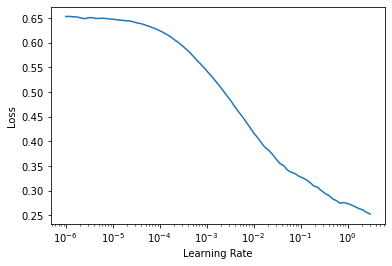

In [27]:
learn.lr_find(suggestions=True, start_lr=1e-06, end_lr=1e2)

epoch,train_loss,valid_loss,accuracy_multi,bal_acc_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.318516,198.203690,0.792704,0.737806,0.583778,0.578972,0.896640,0.580913,00:00
1,0.220050,138.770386,0.686333,0.569078,0.382333,0.389143,0.749013,0.385387,00:00
2,0.171957,27.636671,0.794518,0.739650,0.589478,0.581331,0.897969,0.584399,00:00
3,0.143883,0.927378,0.959741,0.949116,0.951189,0.918866,0.979366,0.934049,00:00
4,0.127460,0.285789,0.970222,0.962863,0.960148,0.942758,0.982967,0.951144,00:00
5,0.113749,0.128694,0.973074,0.966488,0.964199,0.948532,0.984444,0.956082,00:00
6,0.102588,0.112810,0.972296,0.964113,0.970911,0.940876,0.987352,0.955005,00:00
7,0.095317,0.090007,0.974407,0.968036,0.967506,0.950490,0.985582,0.958673,00:00
8,0.088867,0.085518,0.974444,0.968287,0.966058,0.951621,0.984953,0.958614,00:00
9,0.083530,0.084918,0.974407,0.968404,0.965405,0.952180,0.984627,0.958589,00:00


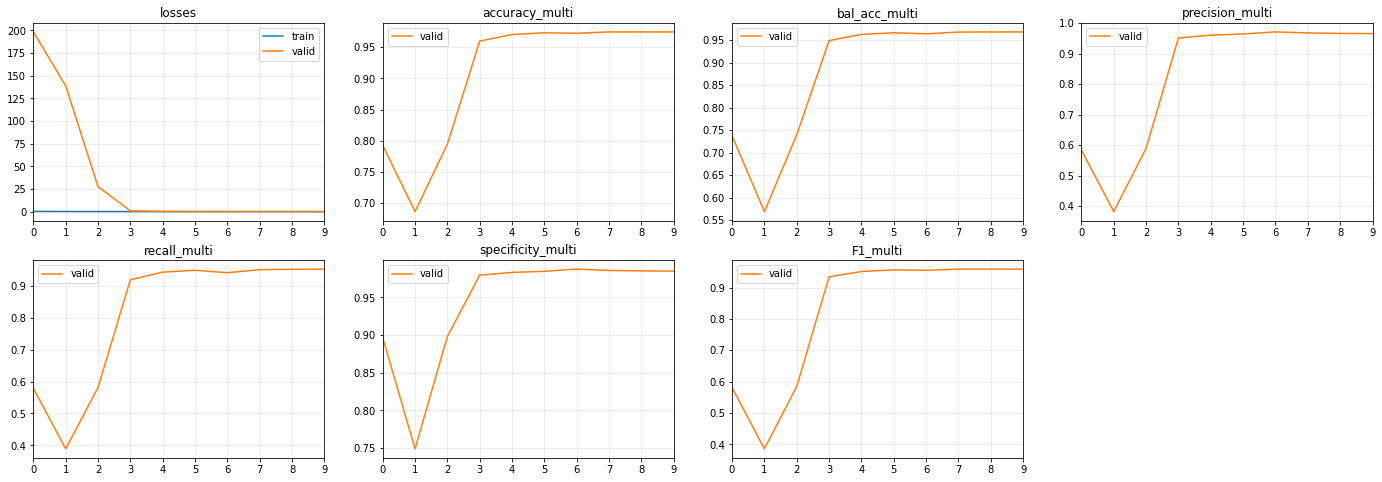

In [28]:
learn.fit_one_cycle(10, lr_max=1e-1)
learn.plot_metrics()

epoch,train_loss,valid_loss,accuracy_multi,bal_acc_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.062504,0.083952,0.974370,0.968530,0.964594,0.952745,0.984316,0.958493,00:00
1,0.058198,0.082127,0.974778,0.969187,0.964324,0.954214,0.984160,0.959131,00:00
2,0.056801,0.081754,0.974889,0.969036,0.964734,0.953433,0.984639,0.958908,00:00
3,0.055968,0.084471,0.975259,0.968242,0.970478,0.949276,0.987208,0.959435,00:00
4,0.056596,0.083530,0.975704,0.968676,0.971766,0.949539,0.987813,0.960112,00:00
5,0.055276,0.080338,0.975741,0.969722,0.967115,0.953658,0.985786,0.960155,00:00
6,0.054186,0.081038,0.975889,0.969274,0.969569,0.951563,0.986985,0.960239,00:00
7,0.053472,0.083260,0.975963,0.968832,0.972380,0.949387,0.988277,0.960365,00:00
8,0.053088,0.083163,0.976000,0.968945,0.972193,0.949724,0.988166,0.960448,00:00
9,0.051409,0.082303,0.976111,0.969333,0.970837,0.951149,0.987517,0.960594,00:00


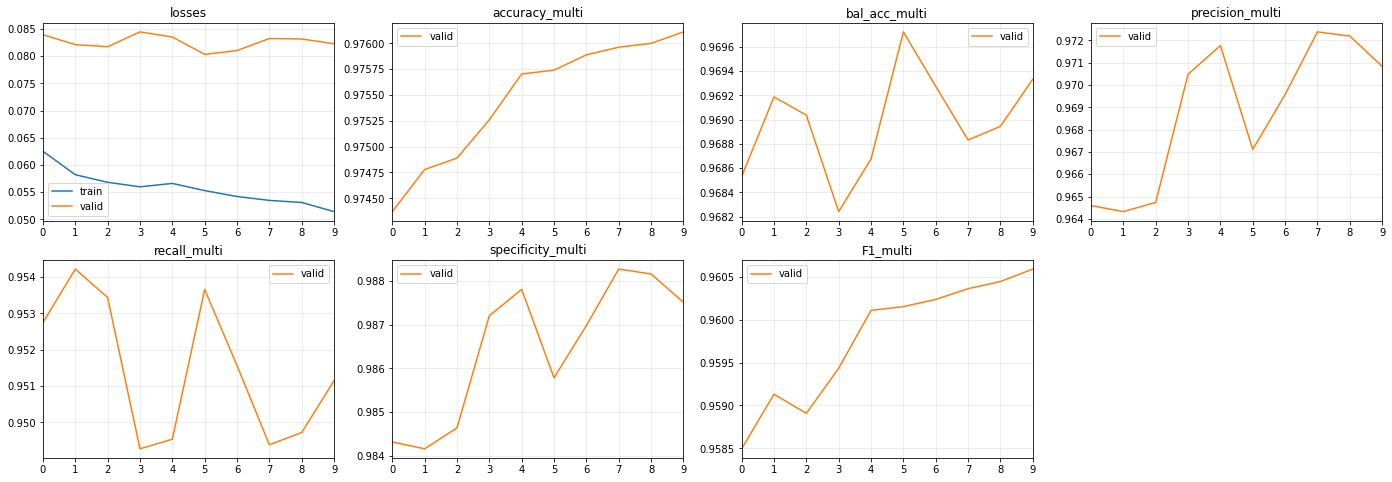

In [29]:
learn.fit_one_cycle(10, lr_max=1e-2)
learn.plot_metrics()

## Optionally Use Position Weights

- Include Per-label positive weights bias the loss function to give greater important to samples where label is present with loss function

### Compute class weights (and vocabulary)

In [30]:
label_counts_multi = collections.Counter([z for r in y_multi for z in r])
label_counts_multi

Counter({'Nor': 2919,
         'RoT': 1767,
         'Pre': 2057,
         'PVC': 96,
         'SPC': 194,
         'Unk': 24})

In [31]:
vocab, counts = zip(*label_counts_multi.items())
N = len(y_multi)
pw = [(N-c)/c if c > 0 else 1.0 for c in counts]   # compute weights

### Prepare Dataset

- Explicitly specify vocabulary to ensure (later) the correct ording of weights 

In [32]:
tfms  = [None, [MultiCategorize(vocab=vocab), OneHotEncode]]
dsets = TSDatasets(X, y_multi, tfms=tfms, splits=splits)

/home/doug/anaconda3/envs/tsai2/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [33]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], 
                               batch_tfms=[TSStandardize()], num_workers=0)

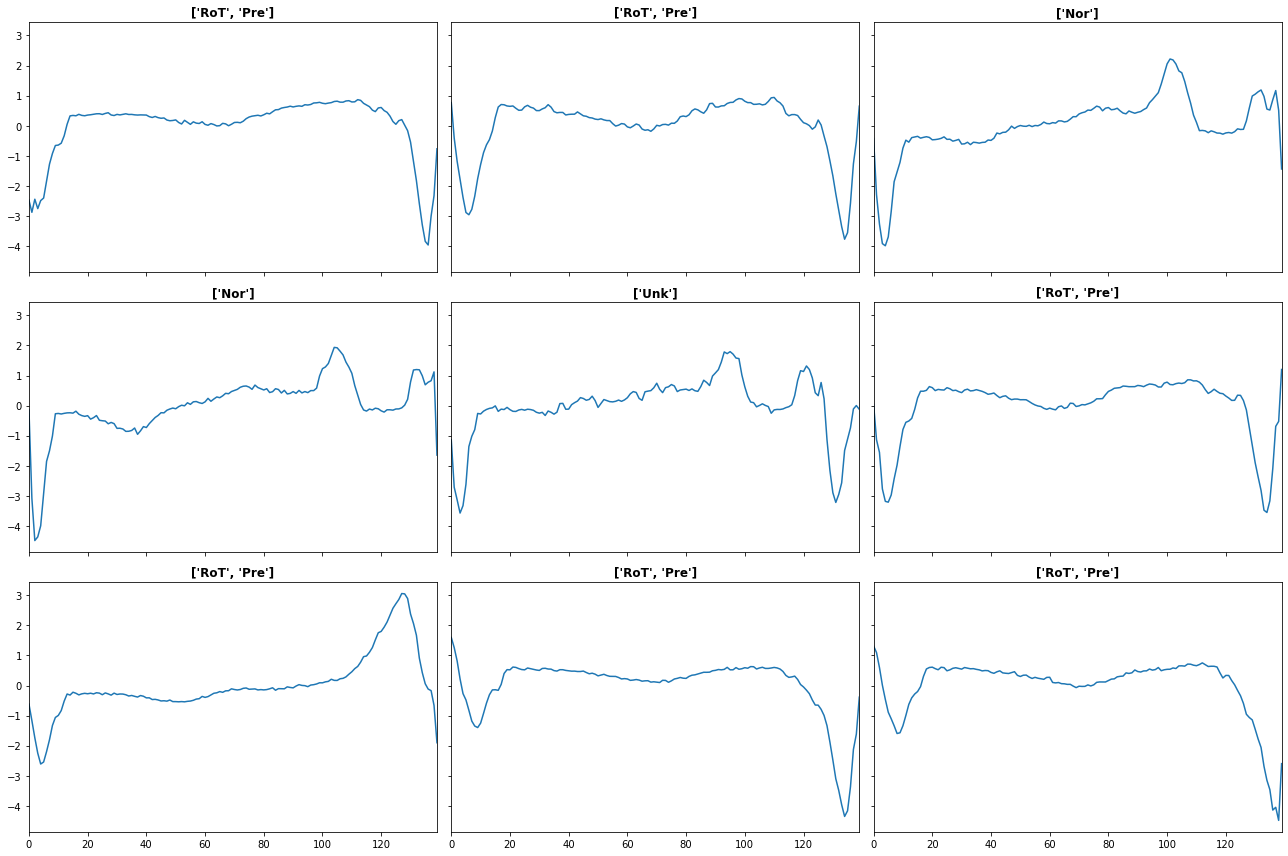

In [34]:
dls.show_batch(sharey=True)

### Build Learner and Train

- Include class weights with ```loss_func```
- Weights must be in form of tensor and placed on GPU (```tensor(pw).cuda()```) before use.

In [35]:
learn = ts_learner(dls, InceptionTime,
                       metrics=[accuracy_multi, bal_acc_multi, precision_multi, recall_multi, 
                                specificity_multi, F1_multi], 
                       loss_func=BCEWithLogitsLossFlat(pos_weight=tensor(pw).cuda())
                  )

SuggestedLRs(lr_min=0.003630780428647995, lr_steep=1.5848931070649996e-05)

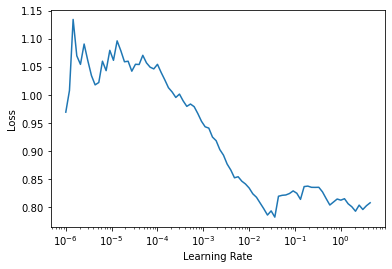

In [36]:
learn.lr_find(suggestions=True, start_lr=1e-06, end_lr=1e2)

epoch,train_loss,valid_loss,accuracy_multi,bal_acc_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.960614,1.048887,0.532037,0.627458,0.306940,0.827729,0.427186,0.442873,00:00
1,0.799302,1.963940,0.450222,0.417412,0.206536,0.418438,0.416385,0.276474,00:00
2,0.742198,8.647570,0.367222,0.362352,0.202015,0.401236,0.323469,0.268432,00:00
3,0.709101,9.211356,0.479185,0.538097,0.210624,0.602338,0.473857,0.310122,00:00
4,0.636799,3.731557,0.608963,0.693359,0.347922,0.832797,0.553920,0.482205,00:00
5,0.560339,0.693820,0.920963,0.935151,0.809937,0.972362,0.897941,0.881025,00:00
6,0.497130,0.769626,0.920370,0.935021,0.845039,0.978738,0.891304,0.899329,00:00
7,0.442143,0.780328,0.933481,0.943181,0.866597,0.972370,0.913992,0.911653,00:00
8,0.398920,0.790195,0.932963,0.943304,0.865369,0.974389,0.912219,0.911535,00:00
9,0.364250,0.755480,0.924222,0.937726,0.849527,0.978292,0.897161,0.902462,00:00


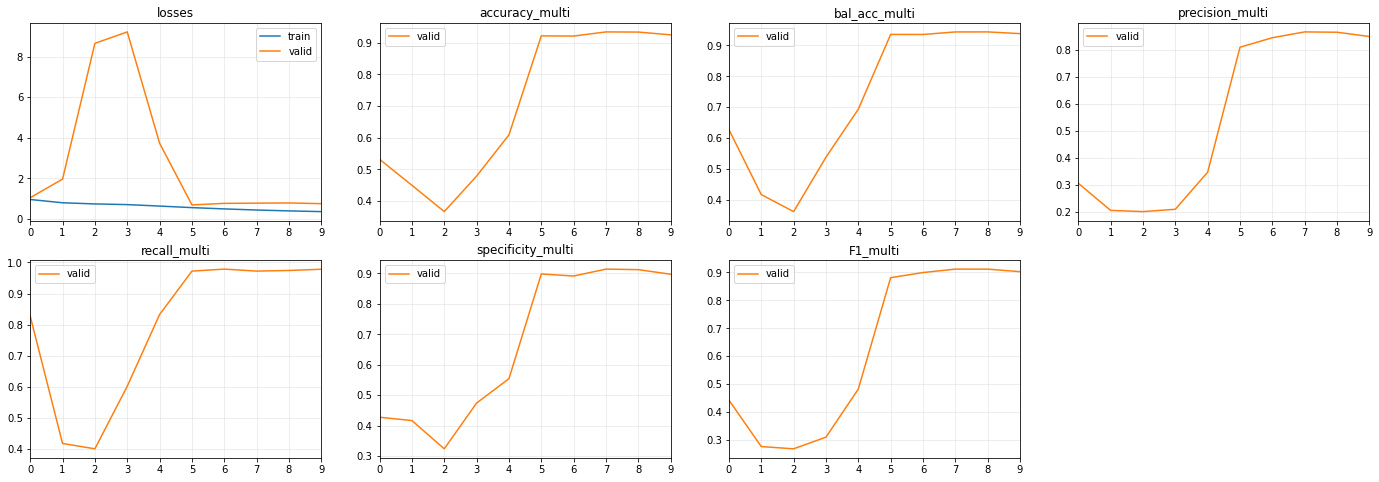

In [37]:
learn.fit_one_cycle(10, lr_max=1e-2)
learn.plot_metrics()

### Try Again with Reduced Weights (reduce by sqrt)

In [38]:
learn = ts_learner(dls, InceptionTime,
                       metrics=[accuracy_multi, bal_acc_multi, precision_multi, recall_multi, 
                                specificity_multi, F1_multi], 
                       loss_func=BCEWithLogitsLossFlat(pos_weight=tensor(pw).sqrt().cuda())
                  )

SuggestedLRs(lr_min=0.30199518203735354, lr_steep=0.0027542286552488804)

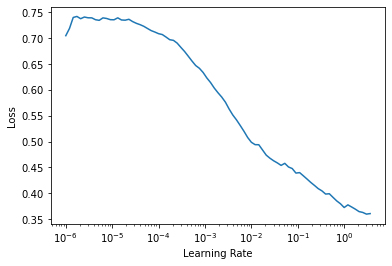

In [39]:
learn.lr_find(suggestions=True, start_lr=1e-06, end_lr=1e2)

In [40]:
learn.fit_one_cycle(10, lr_max=1e-1)

epoch,train_loss,valid_loss,accuracy_multi,bal_acc_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.471260,38.696491,0.939259,0.922101,0.877218,0.882859,0.961342,0.878884,00:00
1,0.408244,792.324341,0.372333,0.370563,0.205667,0.418551,0.322575,0.275617,00:00
2,0.346389,27.726381,0.793704,0.739174,0.588520,0.581432,0.896917,0.584152,00:00
3,0.302275,0.454100,0.923407,0.934525,0.850618,0.969148,0.899902,0.899737,00:00
4,0.267733,0.260164,0.973926,0.971003,0.953529,0.964354,0.977651,0.958701,00:00
5,0.234685,0.241391,0.971407,0.966053,0.940187,0.957497,0.974608,0.948514,00:00
6,0.213384,0.213587,0.913815,0.930516,0.835031,0.980914,0.880118,0.892838,00:00
7,0.194333,0.190420,0.967148,0.968202,0.931747,0.972161,0.964243,0.950855,00:00
8,0.178471,0.186342,0.975037,0.973199,0.955173,0.968685,0.977712,0.961699,00:00
9,0.164986,0.189972,0.976037,0.973731,0.958483,0.967829,0.979634,0.963027,00:00


## Summary of Key Points: Multi-Label Classification


#### Basic Data Preparation
- Replace earlier ```tfms  = [None, [Categorize()]]```  with ```tfms  = [None, [MultiCategorize, OneHotEncode]]```
  - Note:  ```OneHotEncode``` must be included explicitly
- Calling TSDatasets with ```inplace=False``` causes in error in subsequent ```dls = TSDataLoaders.from_dsets() ``` step
- Warning message *Creating an ndarray from ragged nested sequences* is expected behavior

#### Basic Learner

- Use ```learn = ts_learner()```.  Use of ```learn = Learner()``` will fail
- Also include model name in ```ts_learner``` rather than passing pre-created model
- Use ```metrics=accuracy_multi``` in place of ```metrics=accuracy``` used inn earlier multi-class example
- Explicitly specify loss function ```loss_func=BCEWithLogitsLossFlat()```. If omitted, loss function will be ```FlattenedLoss of MSELoss()```.
  
#### Multi-Label Metrics
- High number of negative label values can distort matrics such as accuracy
- Consider using multi=label metrics, such as those included in this example

#### Optionally Include Positive Weights with Loss Function
- Since large number of negative targets after application of binary encoding, label weighting can better optimize loss function for positive labels
- Determine vocabulation and population counts
  - Computes weights, such as pw = (N-pop)/pop.
- Include vocabulary explicitly: ```MultiCategorize(vocab=vocab)```
- Include weights with loss function: ```BCEWithLogitsLossFlat(pos_weight=tensor(pw).cuda()```
  - Weights must be in tensor form and placed on GPU
  - Strict weighting by False/True ratio may yield sub-optimal results.  Consider reduced weights: ```BCEWithLogitsLossFlat(pos_weight=tensor(pw).sqrt().cuda()```
